<a href="https://colab.research.google.com/github/kevinhoffmanglyde/oxfordgenaigroup2/blob/main/Group2EndtoEnd_onehot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement:#

**Demand Forecasting:**
Machine learning techniques has been leveraged to
analyse trends and patterns in sales data, making predictions more reliable and robust against market volatility.

The most challenging user story is to predict what stock we need to order for the coming month.  This is calculated in the BI tool based on predictions for the current month, predictions for the upcoming month, and "real" values for warehouse stock.

Each of the model predictions are included in this evaluation.




## Overview:

We import the needed libraries. Mount the dataset. Perform initial data exploration, cleansing and bring out insights with various visualization plots. We then apply the different algorithms - Linear Regression, Random Forest and Gradient Boost. Scaling, One hot encoding, Cross Validation have also been employed. Various evaluation matrices have been used to compare the models. The file is then saved as a csv to be accessed by Power BI.

Each of the models is re-trained and optimised by the Colab Runtime.  The expectation is that this will be run monthly, so it does not have to be quick but should be flexible enough to retrain for best results.

## Import libraries

In [57]:
!!pip install scikeras[tensorflow-cpu]
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [58]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Mount the Google Drive

In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Load the data

In [60]:
df = pd.read_csv('gdrive/MyDrive/Complete_Sales_Data_Final.csv')

#Set the Date to Split variable
This would be dynamic in a production system

In [61]:
datetosplit = 202402

## Validate the data existence

In [62]:
df.head()

,Country,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,Product Subcategory
0,France,2023-01,7,1,-0.4,98.5,73,1.82,2023-01-01,Mens Jackets
1,France,2023-01,7,1,-0.4,98.5,78,1.82,2023-01-01,Mens Jackets
2,France,2023-01,7,1,-0.4,98.5,73,1.82,2023-01-01,Mens Jackets
3,France,2023-01,7,1,-0.4,98.5,83,1.82,2023-01-01,Mens Jackets
4,France,2023-01,7,1,-0.4,98.5,83,1.82,2023-01-01,Mens Jackets


## Yearly product sales by country

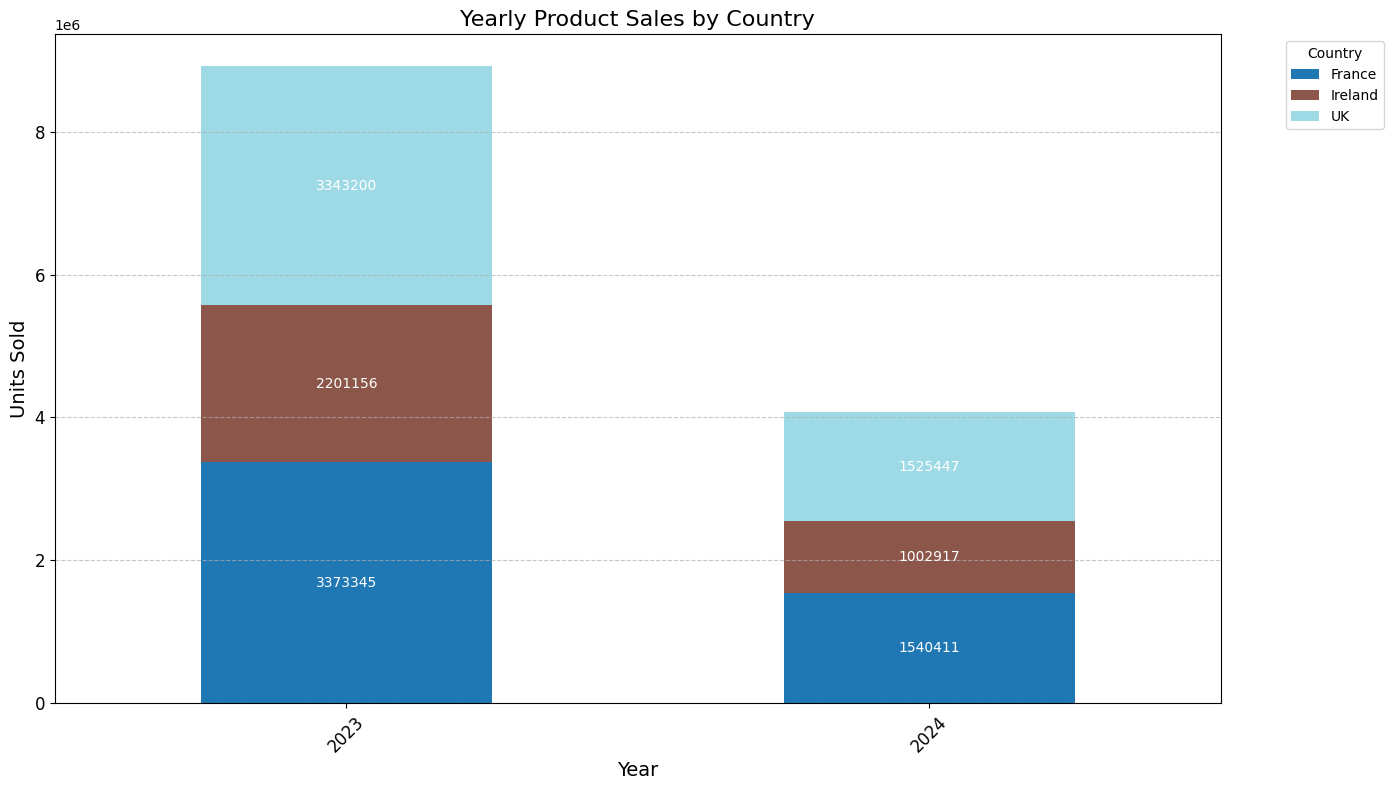

In [63]:
#  Plotting Yearly product sales by country

# Convert 'Date of Sale' column to datetime
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])

# Extract the year from the 'Date of Sale' column
df['year'] = df['Date of Sale'].dt.year

# Group by year and country, then sum the units sold
yearly_sales = df.groupby(['year', 'Country'])['Units Sold'].sum().unstack()

# Plot the data
plt.figure(figsize=(14, 8))
ax = yearly_sales.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())

plt.title('Yearly Product Sales by Country', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, color='white', fmt='%.0f')

plt.tight_layout()
plt.show()

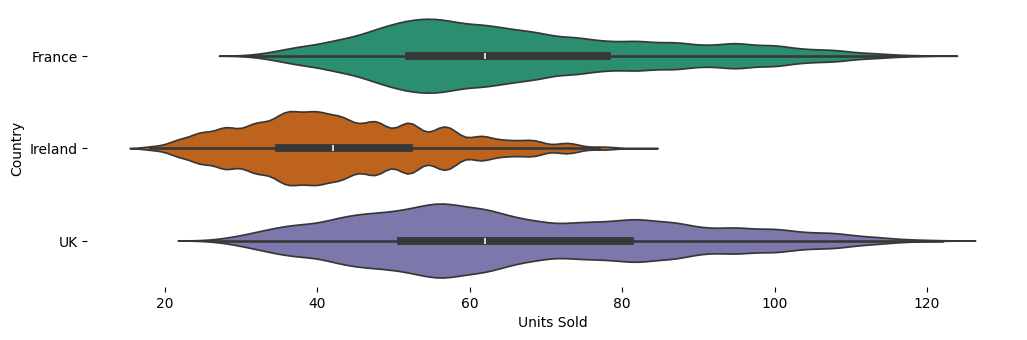

In [64]:
# @title Country vs Units Sold

figsize = (12, 1.2 * len(df['Country'].unique()))
plt.figure(figsize=figsize)
sn.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')
sn.despine(top=True, right=True, bottom=True, left=True)

This reflects a little more reality what with UK and France having higher populations.

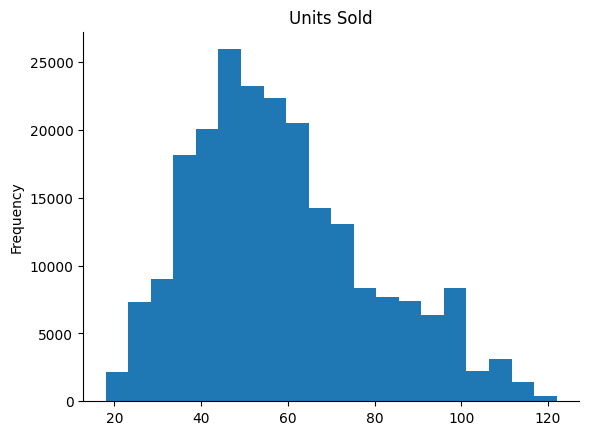

In [65]:
# @title Units Sold

df['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Pair plot

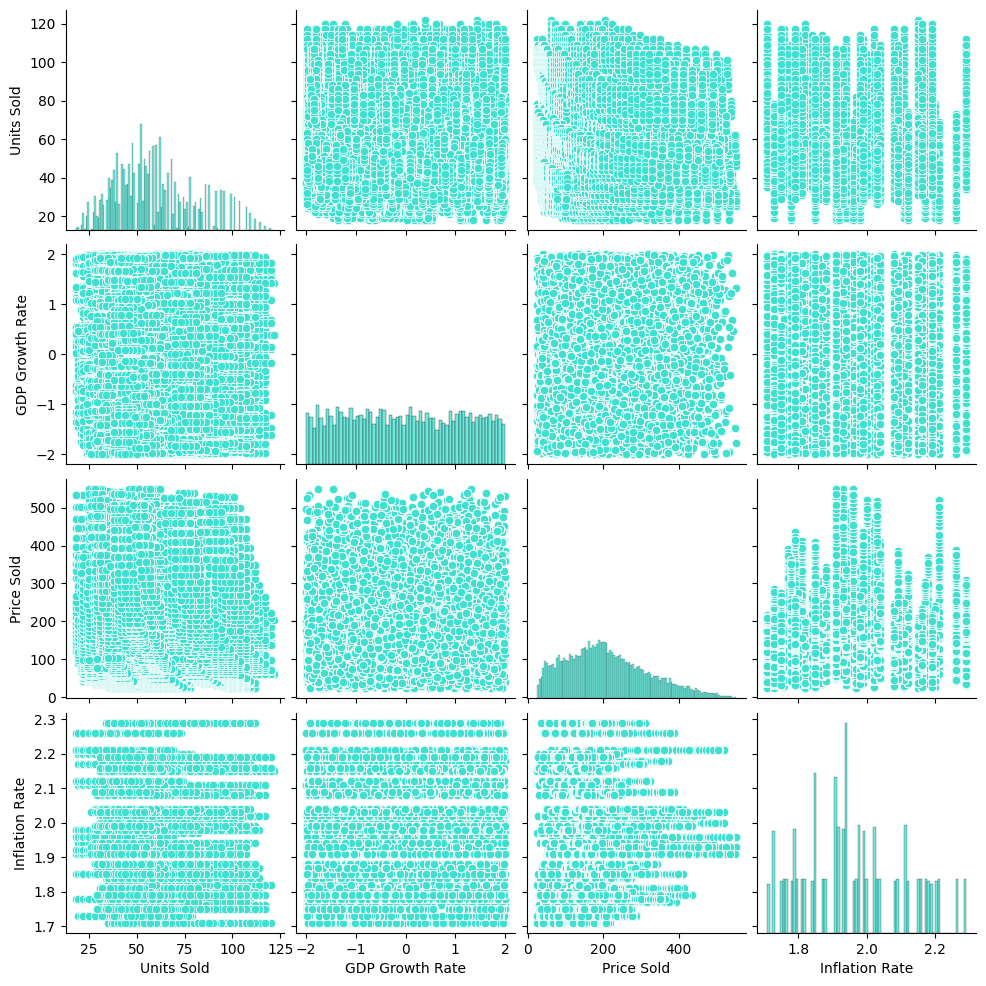

In [66]:
# Ensure all data is numeric and clean
numerical_columns = ['Units Sold', 'GDP Growth Rate', 'Price Sold', 'Inflation Rate']
pairplot_data = df[numerical_columns].apply(pd.to_numeric, errors='coerce').dropna()

# Generate pairplot with turquoise color
sn.pairplot(pairplot_data, plot_kws={'color': '#40E0D0'}, diag_kws={'color': '#40E0D0'})
plt.show()


## Monthly sales over years

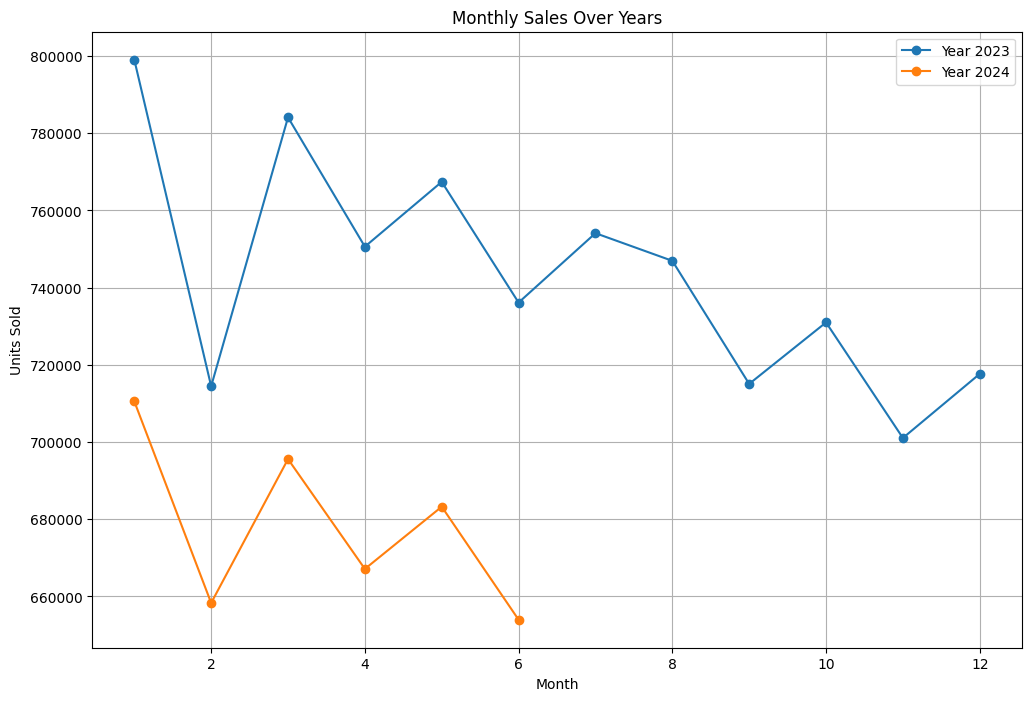

In [67]:
# Ensure the 'Date of Sale' column is in datetime format
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])

# Extract year and month
df['Year'] = df['Date of Sale'].dt.year
df['Month'] = df['Date of Sale'].dt.month

# Aggregate units sold by month and year
monthly_sales = df.groupby(['Year', 'Month'])['Units Sold'].sum().unstack(level=0)

# Plot
plt.figure(figsize=(12, 8))
for year in monthly_sales.columns:
    plt.plot(monthly_sales.index, monthly_sales[year], marker='o', label=f'Year {year}')

plt.title('Monthly Sales Over Years')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


## Distribution of Product Category over the years

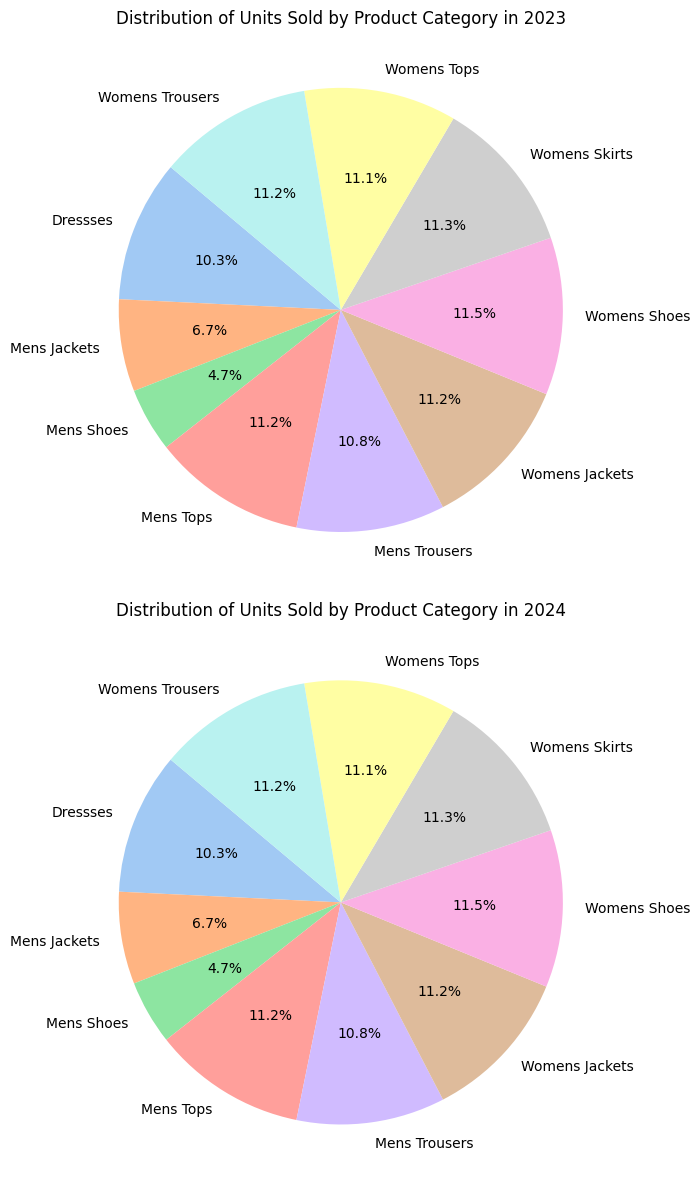

In [68]:
# Extract year from the 'Date of Sale' column
df['Year'] = df['Date of Sale'].dt.year

# Aggregate data
units_sold_by_year_category = df.groupby(['Year', 'Product Subcategory'])['Units Sold'].sum().unstack()

# Plot pie charts for each year
years = units_sold_by_year_category.index
num_years = len(years)
fig, axes = plt.subplots(num_years, 1, figsize=(12, 6 * num_years))

for i, year in enumerate(years):
    ax = axes[i] if num_years > 1 else axes
    units_sold_by_category = units_sold_by_year_category.loc[year].dropna()
    units_sold_by_category.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sn.color_palette('pastel'), ax=ax)
    ax.set_title(f'Distribution of Units Sold by Product Category in {year}')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


## Units Sold vs Product id

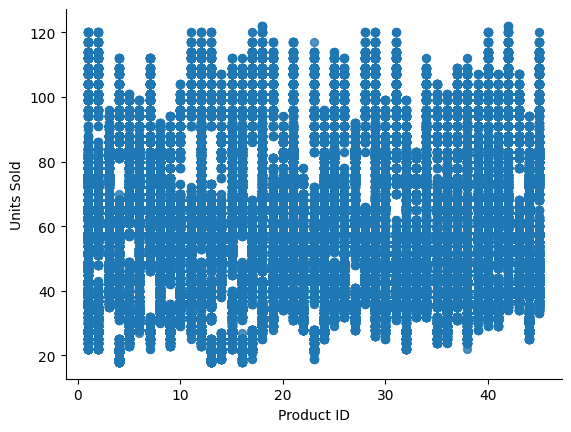

In [69]:
df.plot(kind='scatter', x='Product ID', y='Units Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

##Now examine the data
The biggest worry is that once we get to the testing of the model, using the synthetic data, we may be trying to map the model based on the training data to data that is completely random.
The data we have is for all of 2023 and up to the end of April 2024.  The method for creating the synthetic data is included in a document, but in short - the Price Sold and Units Sold are created by tracking the Inflation Rate.  Then the units sold are slightly randomised to imitate freedom of choice.

In [70]:
import pandas as pd
import numpy as np
import datetime
reference_date = datetime.date(1970, 1, 1)
# train_test_split is used to easily divide data into training and testing sets.
from sklearn.model_selection import train_test_split
# LinearRegression is the model we'll be using from scikit-learn.
from sklearn.linear_model import LinearRegression
# mean_absolute_error and mean_squared_error are metrics to evaluate our model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# matplotlib.pyplot is used for plotting graphs.
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

The store ID is unique, and there are 3 stores per country.
The price per product should match for each store in the country on a given date.

In [71]:
df = df.sort_values(["Date of Sale"], ascending = (True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,Country,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,Product Subcategory,year,Year
0,France,1,7,1,-0.40,98.5,73,1.82,2023-01-01,Mens Jackets,2023,2023
46014,France,1,9,29,0.17,179.5,65,1.82,2023-01-01,Womens Skirts,2023,2023
46013,France,1,9,29,0.17,179.5,71,1.82,2023-01-01,Womens Skirts,2023,2023
46012,France,1,9,29,0.17,179.5,69,1.82,2023-01-01,Womens Skirts,2023,2023
46011,France,1,9,29,0.17,179.5,68,1.82,2023-01-01,Womens Skirts,2023,2023


In [72]:
df2 = df.sort_values(["Date of Sale"], ascending = (False)) # order the data by year, month, day in ascending order.
df2.head() # check the data again by viewing the first 5 rows

,Country,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,Product Subcategory,year,Year
221534,UK,6,6,45,-0.45,505.61,54,1.91,2024-06-01,Womens Shoes,2024,2024
108243,Ireland,6,1,21,1.93,407.63,58,1.96,2024-06-01,Womens Tops,2024,2024
124659,Ireland,6,2,31,1.22,436.95,36,1.96,2024-06-01,Dressses,2024,2024
108232,Ireland,6,1,21,1.93,407.63,57,1.96,2024-06-01,Womens Tops,2024,2024
108231,Ireland,6,1,21,1.93,407.63,61,1.96,2024-06-01,Womens Tops,2024,2024


In [73]:
df['Date of Sale']

0        2023-01-01
46014    2023-01-01
46013    2023-01-01
46012    2023-01-01
46011    2023-01-01
            ...    
178834   2024-06-01
178833   2024-06-01
178832   2024-06-01
178840   2024-06-01
221534   2024-06-01
Name: Date of Sale, Length: 221535, dtype: datetime64[ns]

There were issues with the date formatting, so this was a reasonable test.

In [74]:
df.describe()

,Month,Store ID,Product ID,GDP Growth Rate,Price Sold,Units Sold,Inflation Rate,Date of Sale,year,Year
count,221535.000000,221535.000000,221535.000000,221535.000000,221535.000000,221535.000000,221535.000000,221535,221535.000000,221535.000000
mean,5.519196,5.000000,23.000000,-0.018219,211.408857,58.620426,1.961255,2023-09-16 07:03:50.347349248,2023.332724,2023.332724
min,1.000000,1.000000,1.000000,-2.000000,23.500000,18.000000,1.710000,2023-01-01 00:00:00,2023.000000,2023.000000
25%,3.000000,3.000000,12.000000,-1.020000,127.400000,43.000000,1.850000,2023-05-01 00:00:00,2023.000000,2023.000000
50%,5.000000,5.000000,23.000000,-0.030000,197.780000,55.000000,1.940000,2023-10-01 00:00:00,2023.000000,2023.000000
75%,8.000000,7.000000,34.000000,1.000000,281.660000,70.000000,2.080000,2024-02-01 00:00:00,2024.000000,2024.000000
max,12.000000,9.000000,45.000000,2.000000,550.190000,122.000000,2.290000,2024-06-01 00:00:00,2024.000000,2024.000000
std,3.307124,2.581995,12.987202,1.153344,110.652063,20.515611,0.148290,NaN,0.471190,0.471190


In [75]:
print(df['Units Sold'])

0         73
46014     65
46013     71
46012     69
46011     68
          ..
178834    60
178833    56
178832    52
178840    35
221534    54
Name: Units Sold, Length: 221535, dtype: int64


In [76]:
df.isnull().sum()

Country                0
Month                  0
Store ID               0
Product ID             0
GDP Growth Rate        0
Price Sold             0
Units Sold             0
Inflation Rate         0
Date of Sale           0
Product Subcategory    0
year                   0
Year                   0
dtype: int64

Looks like no Nulls, which is expected for our synthetic data.

In [77]:
df['Units Sold'].isna().sum()

0

Tidy up some of the data columns just in case.
Doing a drop method rather than inplace replacement.

In [78]:
#clean up any nulls that might come through in real data
df = df.dropna(subset=['Store ID', 'Product ID', 'Date of Sale'])

##Check out the distribution of the data

In [79]:
unique_store = df['Store ID'].nunique()
unique_product = df['Product ID'].nunique()
#unique_product_cat = df['Product Category'].nunique()
unique_country = df['Country'].nunique()
unique_pricesold = df['Price Sold'].nunique()
unique_dates = df['Date of Sale'].nunique()

print("Distinct Stores:", unique_store)
print("Distinct Products:", unique_product)
#print("Distinct Product Categories:", unique_product_cat)
print("Distinct Countries:", unique_country)
print("Distinct Prices:", unique_pricesold)
print("Distinct Dates:", unique_dates)

Distinct Stores: 9
Distinct Products: 45
Distinct Countries: 3
Distinct Prices: 6122
Distinct Dates: 18


Data above looks OK.
Stores, Products, Categories and Countries look like the specifications in the data.
Prices have a different value for each country and each product for each month.

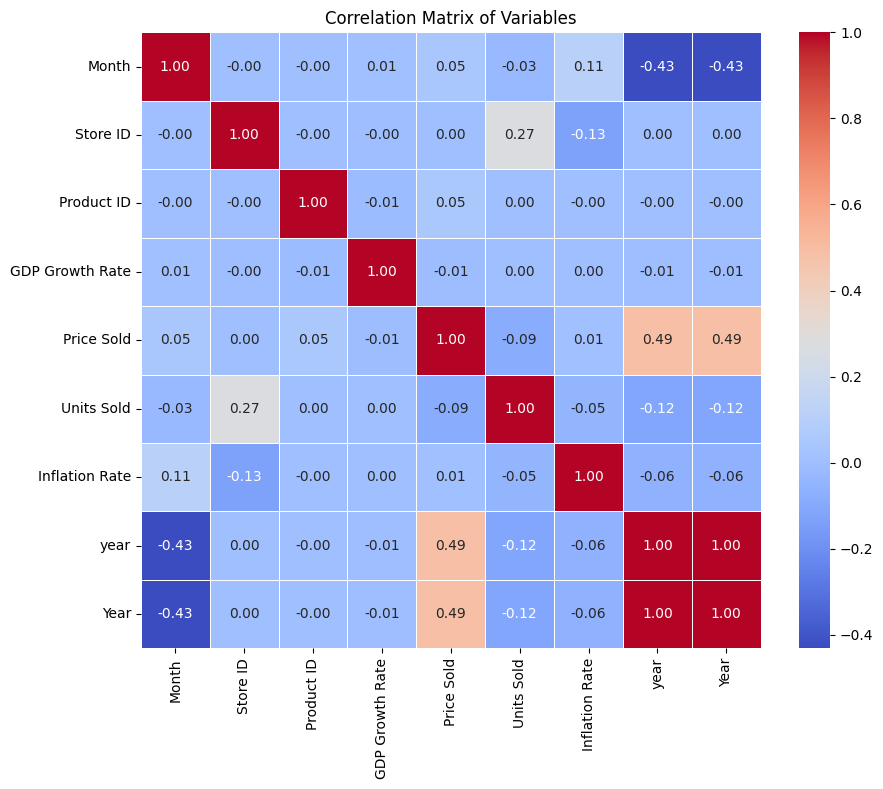

In [80]:
# Calculating the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')

# Displays the plot. Without this, the figure would not be shown in a notebook.
plt.show()

This has been quite puzzling.  The original data set had a direct negative correlation to Inflation for Units Sold (then a small randomisation to reflect that units sold is not exactly the same for every day), and a positive correlation to Price Sold.  This was by design.  It did not show up as a significant correlation in this matrix.

Units sold were adjusted from the Inflation Rate by Country and Store ID, so this Store ID correlation makes sense.

In [81]:
#df['Date of Sale'] = pd.to_datetime(df['Date of Sale'], format='%d/%m/%Y')
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
min_sale_date = df['Date of Sale'].min()
max_sale_date = df['Date of Sale'].max()

print("Minimum date:", min_sale_date)
print("Maximum date:", max_sale_date)

Minimum date: 2023-01-01 00:00:00
Maximum date: 2024-06-01 00:00:00


Date range as expected.

#Date issues##
Since we are trying to predict future demand, this suggests that when we divide the Training and Test data, we need to do this on a date basis.  Including dates in the training set that should appear in the test set is not desired.  When using this on real data in production, the future dates will all be empty.

So, selecting out test and train data set should be on dates rather than simply a percentage of the dataset.  I have used most of the data for training, but left out 3 months of the 15 as test data.

Once the data split is completed, I dropped the Date of Sale and aggregated the data to the month.

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


#Set the monthly values
Price Sold
Inflation Rate
Units Sold
###Ignoring GDP Growth Rate as that is going to be dropped

In [83]:
df['YearMonth'] = df['Date of Sale'].dt.year*100+df['Date of Sale'].dt.month
df['Month'] = df['Date of Sale'].dt.month
X = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Country', 'Product Subcategory', 'Month']]
dfa = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Units Sold', 'Country', 'Product Subcategory', 'Month']]
print(dfa)

        Store ID  GDP Growth Rate  Inflation Rate  Price Sold  Product ID  \
0              7            -0.40            1.82       98.50           1   
46014          9             0.17            1.82      179.50          29   
46013          9             0.17            1.82      179.50          29   
46012          9             0.17            1.82      179.50          29   
46011          9             0.17            1.82      179.50          29   
...          ...              ...             ...         ...         ...   
178834         5             1.09            1.91      509.39          19   
178833         5             1.09            1.91      509.39          19   
178832         5             1.09            1.91      509.39          19   
178840         6            -0.29            1.91      519.12          19   
221534         6            -0.45            1.91      505.61          45   

        YearMonth  Units Sold Country Product Subcategory  Month  
0       

In [84]:
# Assuming dfa is your original DataFrame
units_sold_aggregate = dfa.groupby([
    'Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Country', 'Product Subcategory', 'Month'
])['Units Sold'].sum().reset_index()
units_sold_aggregate.rename(columns={'Units Sold': 'Units Sold Aggregate'}, inplace=True)
#units_sold_aggregate = pd.get_dummies(units_sold_aggregate, columns=['Country', 'Product Subcategory', 'Store ID', 'Product ID'], drop_first=False)

price_sold_average = dfa.groupby([
    'Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Product ID', 'YearMonth', 'Country', 'Product Subcategory', 'Month'
])['Price Sold'].mean().reset_index()
price_sold_average.rename(columns={'Price Sold': 'Average Price Sold'}, inplace=True)
#price_sold_average = pd.get_dummies(price_sold_average, columns=['Country', 'Product Subcategory', 'Store ID', 'Product ID'], drop_first=False)
#inflation rate is not necessary as it is the same for each monthly aggregate.

result = pd.merge(units_sold_aggregate, price_sold_average, on=[
    'Store ID', 'GDP Growth Rate', 'Product ID',
    'YearMonth', 'Country', 'Inflation Rate','Country', 'Product Subcategory', 'Month'
], how='inner')

In [85]:
print(result)

      Store ID  GDP Growth Rate  Inflation Rate  Price Sold  Product ID  \
0            1            -2.00            1.85      175.86          31   
1            1            -2.00            2.21      496.69          18   
2            1            -2.00            2.26      208.75          32   
3            1            -1.99            1.73      134.79          44   
4            1            -1.96            1.85      258.37          44   
...        ...              ...             ...         ...         ...   
7285         9             1.97            1.79      415.21          45   
7286         9             1.97            1.84       98.62          13   
7287         9             1.97            1.93      490.38          27   
7288         9             1.97            2.11      151.24          44   
7289         9             1.98            1.82       78.00          43   

      YearMonth  Country Product Subcategory  Month  Units Sold Aggregate  \
0        202303  Irela

#One-Hot
This is an attempt to improve the linear lasso regression as it is sensitive to numbers in the features.  To improve this while not forcing everything into a scale, I will one-hot the Product ID, the Store ID, the Country and the Product Subcategory.  Once we get to the BI layer, they can be reassembled.
In fact, only the Store ID and Product ID need to be reassembled.

In [86]:
result = pd.get_dummies(result, columns=['Country', 'Product Subcategory', 'Store ID', 'Product ID'], drop_first=False)

In [87]:
print(result)

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Month  \
0               -2.00            1.85      175.86     202303      3   
1               -2.00            2.21      496.69     202405      5   
2               -2.00            2.26      208.75     202312     12   
3               -1.99            1.73      134.79     202302      2   
4               -1.96            1.85      258.37     202401      1   
...               ...             ...         ...        ...    ...   
7285             1.97            1.79      415.21     202402      2   
7286             1.97            1.84       98.62     202306      6   
7287             1.97            1.93      490.38     202406      6   
7288             1.97            2.11      151.24     202303      3   
7289             1.98            1.82       78.00     202301      1   

      Units Sold Aggregate  Average Price Sold  Country_France  \
0                     1538              175.86           False   
1              

#Drop the columns we won't be using and rename the aggregates

In [88]:
result.rename(columns={'Units Sold Aggregate': 'Units Sold'}, inplace=True)
result.rename(columns={'Average Price Sold': 'Price Sold'}, inplace=True)

In [89]:
#print(result)
Y = result['Units Sold']
X =  result.drop(columns='Units Sold')

#Split the data into Past and "Future" and (Scale the Features?)


In [90]:
#from sklearn.preprocessing import StandardScaler
#standard_scaler = StandardScaler()
X_Train = X[X['YearMonth'] <= datetosplit] #split the X Train
#X_Train_Original = standard_scaler.fit_transform(X_Train) #keep the scaled list for later
#X_Train = pd.DataFrame(X_Train_Original, columns=X_Train.columns) #make a data frame of the scaled list
X_Test = X[X['YearMonth'] > datetosplit] #split the X Test
#X_Test_Original = standard_scaler.fit_transform(X_Test) #keep the scaled list for later
#X_Test = pd.DataFrame(X_Test_Original, columns=X_Test.columns) #make a data frame of the scaled list

Y_Train = Y[result['YearMonth'] <= datetosplit]
Y_Test = Y[result['YearMonth'] > datetosplit]
Y_Test = Y_Test.drop(columns=['YearMonth'])
#print("Data on or after the split date:")
print(X_Test)

#print("Data before the split date:")
#print(Y_Train)

#print("Data on or after the split date:")
#print(Y_Test)

min_test_ym = X_Test['YearMonth'].min()
max_train_ym = X_Train['YearMonth'].max()

print('min_test_ym ', min_test_ym )
print('max_train_ym', max_train_ym)

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Month  \
1               -2.00            2.21      496.69     202405      5   
5               -1.96            1.92      139.67     202403      3   
6               -1.96            1.92      323.47     202404      4   
13              -1.92            1.96      482.03     202406      6   
23              -1.87            1.96      363.15     202406      6   
...               ...             ...         ...        ...    ...   
7278             1.93            1.94      262.42     202404      4   
7282             1.96            2.00      191.99     202405      5   
7283             1.96            2.02      310.31     202403      3   
7284             1.96            2.02      407.47     202403      3   
7287             1.97            1.93      490.38     202406      6   

      Price Sold  Country_France  Country_Ireland  Country_UK  \
1         496.69           False             True       False   
5         139.67 

#Linear Regression model
Try to tune the Lasso alpha automatically, then fit using the best alpha.
Once concern is that the Lasso sensitive to the scale of input features.

In [91]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
# Creating an instance of the LinearRegression model.

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
lasso_cv.fit(X_Train, Y_Train)
best_alpha = lasso_cv.alpha_
# Lasso Regression
modelLR = Lasso(alpha=best_alpha)  # Alpha is a hyperparameter for L1 regularization
#modelLR = LinearRegression(alpha=0.1)
# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelLR.fit(X_Train, Y_Train)


Lasso()

In [92]:
# Cross-validating the model
scores = cross_val_score(modelLR, X_Train, Y_Train, cv=3)
print(f"Cross-validated R² scores: {scores}")
print(f"Average R² score: {np.mean(scores)}")

Cross-validated R² scores: [-2.71692142 -1.31266102 -0.0526145 ]
Average R² score: -1.360732315234743


In [93]:
# Use the trained model to make predictions on the testing set.
predictionsLR = modelLR.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.

# Evaluating the model
mse = mean_squared_error(Y_Test, predictionsLR)
r2 = r2_score(Y_Test, predictionsLR)
print('MAE:', mean_absolute_error(Y_Test, predictionsLR))
print('MSE:', mean_squared_error(Y_Test, predictionsLR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLR)))
print(f"R² score: {r2}")

MAE: 256.1107326860601
MSE: 98333.04456571591
RMSE: 313.5810016020038
R² score: 0.7001182567051362


This r2 is much better after Units Sold adjustments by store.  Still not great at .63, but better.  This is after scaling the Inflation Rate and Price Sold and keeping one-hot encoding on Store ID and Product ID.
Scaling Store ID and Product ID may lead to quicker performance, but the R2 is not as good at .49.
One-hot encoding Store ID and Product ID lead to extremely long training on Random Forest and Gradient Boost.  It also required some coding to re-assemble the Product ID and Store ID on the BI tool.

#Reset the indices and merge the datasets

This is the Actual values.

In [94]:
X_Test.reset_index(drop=True, inplace=True)
Y_Test.reset_index(drop=True, inplace=True)
merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
#print(merged_df)
merged_df.describe()

,GDP Growth Rate,Inflation Rate,Price Sold,YearMonth,Month,Price Sold,Units Sold
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,-0.031358,1.973333,303.864623,202404.500000,4.500000,303.864623,1666.616667
std,1.164745,0.082116,127.379666,1.118379,1.118379,127.379666,572.807654
min,-2.000000,1.910000,50.390000,202403.000000,3.000000,50.390000,576.000000
25%,-1.060000,1.920000,199.525000,202403.750000,3.750000,199.525000,1236.000000
50%,-0.085000,1.935000,317.980000,202404.500000,4.500000,317.980000,1572.500000
75%,1.010000,2.005000,408.912500,202405.250000,5.250000,408.912500,1982.500000
max,2.000000,2.210000,550.190000,202406.000000,6.000000,550.190000,3151.000000


#Create the predictions dataframe

In [95]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
print(df_1d)

       Prediction
0     1527.897682
1     1677.001964
2     1392.870900
3     1446.828947
4     1502.605862
...           ...
1615  1339.155228
1616  1469.634458
1617  1507.350450
1618  1464.175419
1619  1475.650973

[1620 rows x 1 columns]


#Merge the the predictions

In [96]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)

#print(predictionsLR_df)

#Plot the actuals and predictions

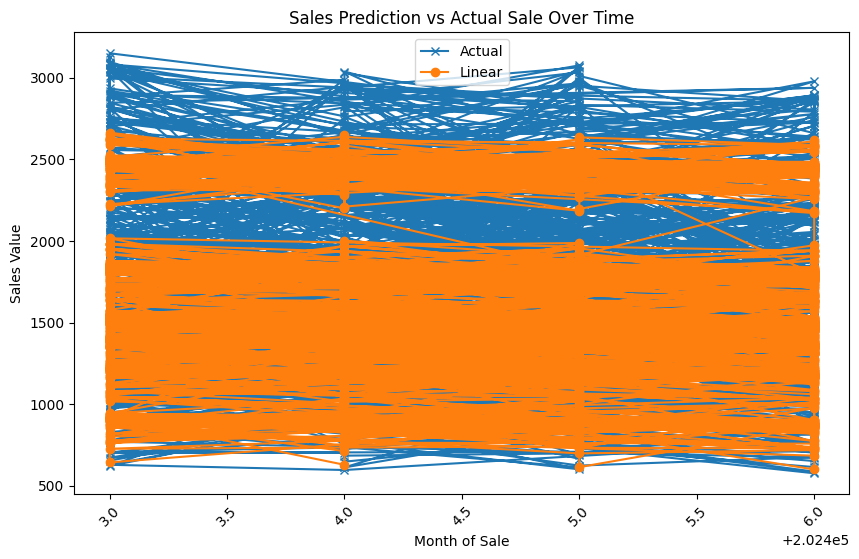

In [97]:
#print(merged_df)
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual', marker='x')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] ,  merged_df2['Prediction'], label='Linear', marker='o')  # Plot Sales Prediction
# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Month of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability
#plt.ylim(0, 150)

# Adding legend
plt.legend()

# Show the plot
plt.show()
#X_Test = X_Test.drop(columns=['Date of Sale'])

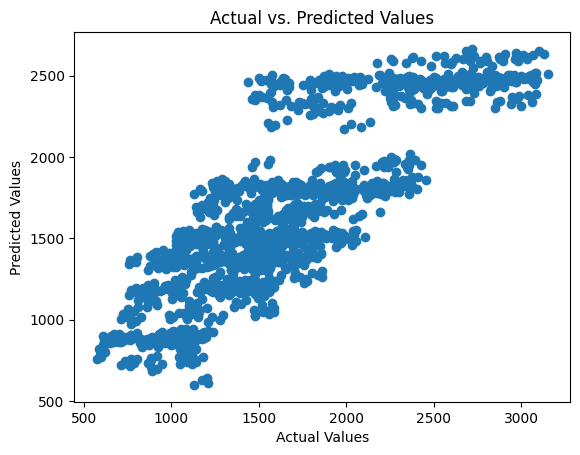

In [98]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

Scatter chart is not perfect.  It shows a semblance of a relationship, but not a good Linear relationship.
Scaling did no favours here.

#LSTM

In [114]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Y_TrainLSTM = pd.Series(Y_Train)     # Replace with your series if it's a single target variable

# Normalize the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_Train)
X_scaled_Test = scaler_X.fit_transform(X_Test)


Y_TrainLSTM = Y_TrainLSTM.values.reshape(-1, 1)

Y_scaled = scaler_Y.fit_transform(Y_TrainLSTM)

# Reshape input to be [samples, time steps, features]
# Here we assume time steps = 1 for simplicity
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_scaled_Test = X_scaled_Test.reshape((X_scaled_Test.shape[0], 1, X_scaled_Test.shape[1]))


########################
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dense(Y_TrainLSTM.shape[1]))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_scaled, Y_scaled, epochs=10, batch_size=32, verbose=1)
###############################

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0681
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3684e-04
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1122e-04
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4608e-04
Epoch 10/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2930e-04


In [115]:
predictions = model.predict(X_scaled_Test)
predictions = scaler_Y.inverse_transform(predictions)
predictionsLSTM = pd.DataFrame(predictions, columns=['Prediction'])

# Print the first few predictions
print(predictionsLSTM.head())

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
    Prediction
0  1287.421753
1  2067.466064
2  1556.151245
3  1809.836792
4  1413.599487


In [116]:
print(Y_Test.head())
print(predictionsLSTM.head())
mse = mean_squared_error(Y_Test, predictionsLSTM)
r2 = r2_score(Y_Test, predictionsLSTM)
print('MAE:', mean_absolute_error(Y_Test, predictionsLSTM))
print('MSE:', mean_squared_error(Y_Test, predictionsLSTM))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLSTM)))
print(f"R² score: {r2}")

0    1232
1    1887
2    1497
3    1941
4    1492
Name: Units Sold, dtype: int64
    Prediction
0  1287.421753
1  2067.466064
2  1556.151245
3  1809.836792
4  1413.599487
MAE: 126.15568708254968
MSE: 25426.800855773618
RMSE: 159.45783409971935
R² score: 0.9224570600786705


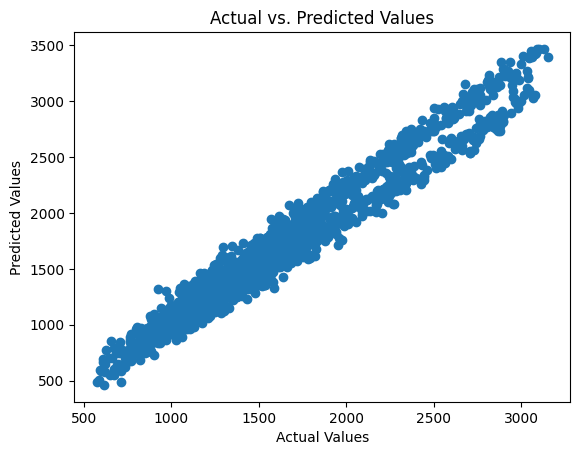

In [117]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLSTM)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

In [142]:
df_5d = pd.DataFrame(predictionsLSTM, columns=['Prediction'])
print(df_5d)

       Prediction
0     1267.559570
1     2040.123535
2     1635.309082
3     1914.918213
4     1330.176025
...           ...
1615  1637.450806
1616  1631.846191
1617  1712.060669
1618  1384.300293
1619  1517.552979

[1620 rows x 1 columns]


#Ridge

In [143]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined as pandas DataFrames and Series
# Example data (you should replace this with your actual data):
np.random.seed(42)
X_train = pd.DataFrame(np.random.rand(100, 10))  # 100 samples, 10 features
y_train = pd.Series(np.random.rand(100))  # 100 target values
X_test = pd.DataFrame(np.random.rand(200, 10))  # 200 samples, 10 features
y_test = pd.Series(np.random.rand(200))  # 200 target values for testing

# Initialize the unlabeled data (X_unlabeled)
X_unlabeled = X_test.copy()

# Initialize the ridge regression model
ridge = Ridge(alpha=1.0)

# Train the initial model
ridge.fit(X_train, y_train)

# Self-training process
threshold = 0.5  # Confidence threshold for adding pseudo-labeled data
max_iterations = 10  # Maximum number of iterations

for iteration in range(max_iterations):
    # Predict on the unlabeled data
    predictions = ridge.predict(X_unlabeled)

    # Calculate confidence (using a simple threshold for now, you can use more sophisticated methods)
    confidence = np.abs(predictions)  # You can define your own confidence measure

    # Select data points with confidence above the threshold
    confident_indices = np.where(confidence > threshold)[0]

    if len(confident_indices) == 0:
        break  # Exit if no confident predictions are found

    # Add the confident predictions to the labeled dataset
    X_train = pd.concat([X_train, X_unlabeled.iloc[confident_indices]], axis=0)
    y_train = pd.concat([y_train, pd.Series(predictions[confident_indices], index=X_unlabeled.iloc[confident_indices].index)], axis=0)

    # Remove the added points from the unlabeled dataset
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices])

    # Re-train the model with the expanded labeled dataset
    ridge.fit(X_train, y_train)

    # Evaluate the model on the test set
    test_predictions = ridge.predict(X_test)
    mse = mean_squared_error(y_test, test_predictions)
    print(f"Iteration {iteration + 1}, Test MSE: {mse:.4f}")

print("Final model trained with self-training process.")

Iteration 1, Test MSE: 0.0932
Final model trained with self-training process.


In [144]:
from sklearn.linear_model import Ridge
# Initialize the ridge regression model
ridge = Ridge(alpha=1.0)
X_train = pd.DataFrame(X_Train)  # 100 samples, 10 features
y_train = pd.Series(Y_Train)  # 100 target values
X_test = pd.DataFrame(X_Test)  # 200 samples, 10 features (unlabeled data)
y_test = pd.Series(Y_Test)
ridge.fit(X_train, y_train)
#X_unlabeled = X_Train
# Self-training process
threshold = 0.95  # Confidence threshold for adding pseudo-labeled data
max_iterations = 10  # Maximum number of iterations
X_unlabeled = X_test.copy()

ridge = Ridge(alpha=1.0)

# Train the initial model
ridge.fit(X_train, y_train)

for iteration in range(max_iterations):
    # Predict on the unlabeled data
    if X_unlabeled.empty:
        print("No more unlabeled data to predict.")
        break

    predictions = ridge.predict(X_unlabeled)

    # Calculate confidence (using a simple threshold for now, you can use more sophisticated methods)
    confidence = np.abs(predictions)  # You can define your own confidence measure

    # Select data points with confidence above the threshold
    confident_indices = np.where(confidence > threshold)[0]

    if len(confident_indices) == 0:
        break  # Exit if no confident predictions are found

    # Add the confident predictions to the labeled dataset
    X_train = pd.concat([X_train, X_unlabeled.iloc[confident_indices]], axis=0)
    y_train = pd.concat([y_train, pd.Series(predictions[confident_indices], index=X_unlabeled.iloc[confident_indices].index)], axis=0)

    # Remove the added points from the unlabeled dataset
    X_unlabeled = X_unlabeled.drop(X_unlabeled.index[confident_indices])

    # Re-train the model with the expanded labeled dataset
    ridge.fit(X_train, y_train)

    # Evaluate the model on the test set
    test_predictions = ridge.predict(X_test)
    mse = mean_squared_error(y_test, test_predictions)
    print(f"Iteration {iteration + 1}, Test MSE: {mse:.4f}")
# Evaluate the model on the test set
predictionsLRR = ridge.predict(X_test)
mse = mean_squared_error(y_test, predictionsLRR)
print(f"Iteration {iteration + 1}, Test MSE: {mse:.4f}")

print("Final model trained with self-training process.")

Iteration 1, Test MSE: 97828.8020
No more unlabeled data to predict.
Iteration 2, Test MSE: 97828.8020
Final model trained with self-training process.


In [145]:
mse = mean_squared_error(Y_Test, predictionsLRR)
r2 = r2_score(Y_Test, predictionsLRR)
print('MAE:', mean_absolute_error(Y_Test, predictionsLRR))
print('MSE:', mean_squared_error(Y_Test, predictionsLRR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLRR)))
print(f"R² score: {r2}")

MAE: 254.58616752505085
MSE: 97828.80203403154
RMSE: 312.7759614069335
R² score: 0.7016560218593908


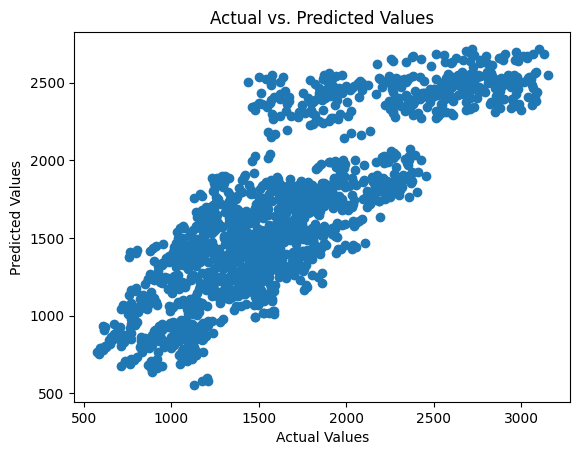

In [146]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLRR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

In [147]:
df_4d = pd.DataFrame(predictionsLRR, columns=['Prediction'])
print(df_4d)

       Prediction
0     1576.086408
1     1734.851491
2     1355.210883
3     1401.894806
4     1507.578988
...           ...
1615  1301.825645
1616  1493.795500
1617  1501.990035
1618  1410.640927
1619  1475.358130

[1620 rows x 1 columns]


#Random Forest
Trying to get the program to tune its own model using GridSearchCV.
This one takes a significant amount of time.

Fitting 3 folds for each of 324 candidates, totalling 972 fits with cv=3.

In [148]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Set up the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Create a RandomForestRegressor object
rf = RandomForestRegressor(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_Train, Y_Train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best model:", best_model)

#best_params = grid_search.best_params_
optimized_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)


optimized_rf.fit(X_Train, Y_Train)

# Make predictions and evaluate the model
from sklearn.metrics import mean_squared_error
# Use the trained model to make predictions on the testing set.
predictionsRF = optimized_rf.predict(X_Test)
#predictionsRF = best_model.predict(X_Test)
mse = mean_squared_error(Y_Test, predictionsRF)
print(f"Mean Squared Error: {mse}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best model: RandomForestRegressor(max_features='auto', random_state=42)
Mean Squared Error: 11306.375632345682


##Evaluate Random Forest performance.

In [149]:
# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
# Evaluating the model
mseRF = mean_squared_error(Y_Test, predictionsRF)
r2RF = r2_score(Y_Test, predictionsRF)
print('MAE:', mean_absolute_error(Y_Test, predictionsRF))
print('MSE:', mean_squared_error(Y_Test, predictionsRF))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsRF)))
print(f"R² score: {r2RF}")

MAE: 78.44075308641975
MSE: 11306.375632345682
RMSE: 106.33144235053751
R² score: 0.9655194685576071


R2 is .89 after Scaling the features with limited one-hot encoding.  This is not as good as with the one-hot encoding on the Store ID and Product ID.  That was a little over .9.  It also had a tighter Linear relationship in the chart below.  This scaling took a lot less time to run, but has its cost.

Taking off the scaling but one-hot encoding the store and product produced an rsquared of 0.9658123364945586.

#Scatter plot of the Predictions v Actual

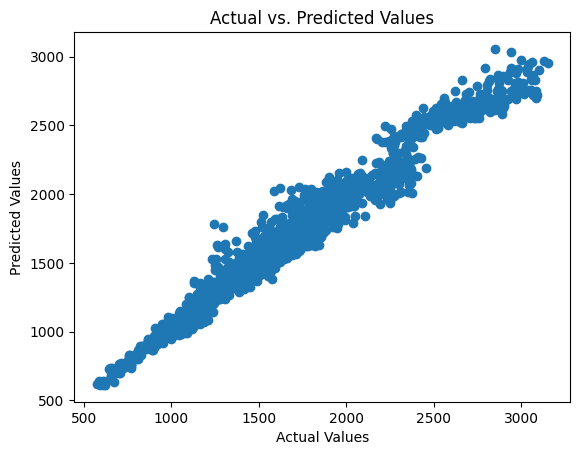

In [150]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsRF)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

Much better linear relationship.

#Gradient Booster

In [151]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Get the application to try to tune the Gradient Booster
As with Random Forest - scoring on neg_mean_squared_error as recommended for Regression models.
Fitting 3 folds for each of 216 candidates, totalling 648 fits, so this takes some time.  Not quite as long as Random Forest.

The idea is that this should run monthly, and should re-train itself each time.  One of the biggest problems with AI Applications is that once the model is trained, it is rarely revisited, leading eventually to a large delta between predictions and reality - making the model potentially detrimental to decision making.

In [152]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'subsample': [0.9, 1.0]
}

# Create the model
gbm = GradientBoostingRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_Train, Y_Train)

# Best model
best_gbm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

best_params = grid_search.best_params_
optimized_gb = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

#optimized_gb.fit(X_Train, Y_Train)

# Evaluate the model
#predictionsGB = optimized_gb.predict(X_Test)
predictionsGB = best_gbm.predict(X_Test)
mae = mean_absolute_error(Y_Test, predictionsGB)
mse = mean_squared_error(Y_Test, predictionsGB)
r2 = r2_score(Y_Test,predictionsGB)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9}
Mean Absolute Error: 329.6148479487282
Mean Squared Error: 154146.92983878186
R² Score: 0.5299052292364216


##Evaluate the Gradient Boost performance.

R2 not very good.  The one-hot encoding on the Store ID and Product ID took a lot more time and effort, but had R2 over .5.  Might be better with more data.  We are now testing on 4 of 30 months.

##Plot the Gradient Boost results

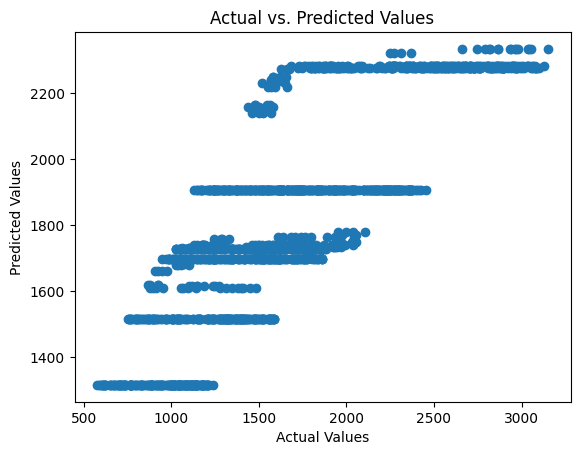

In [153]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsGB)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Invert the scale on X_Test for output to BI
Then merge X_Test with the predictions
Note - there were some issues with the inversed one-hot encoded values.  Some of the True/False values remained scaled to decimal numbers.  Fortunately, these are not required for the BI output.

In [154]:
#descaled = standard_scaler.inverse_transform(X_Test_Original)
#X_Test = pd.DataFrame(descaled, columns=X_Test.columns)
merged_df = pd.merge(X_Test , Y_Test, left_index=True, right_index=True)
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predictionsRF, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)


#Plot all predictions against the Actual.

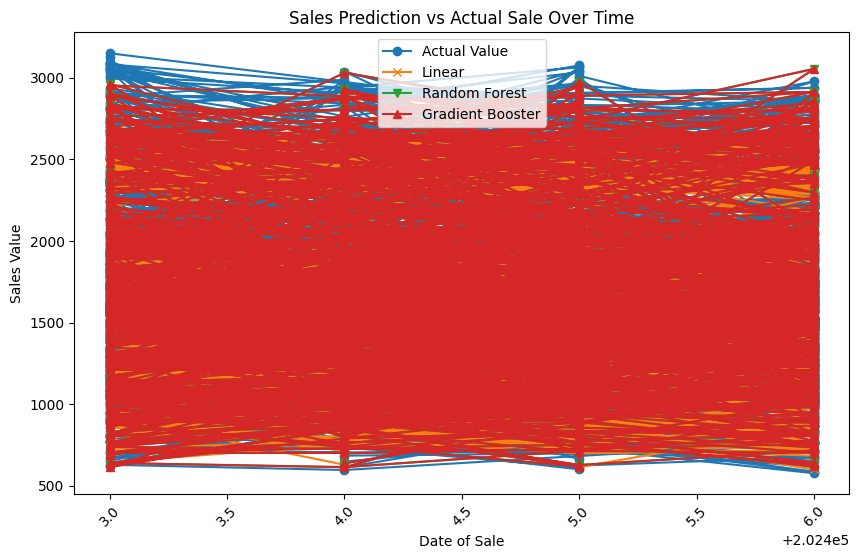

In [155]:
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual Value', marker='o')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] , merged_df2['Prediction'], label='Linear', marker='x')  # Plot Sales Prediction
plt.plot(merged_df3['YearMonth'] , merged_df3['PredictionRF'], label='Random Forest', marker='v')  # Plot Sales Prediction
plt.plot(merged_df4['YearMonth'] , merged_df4['PredictionGB'], label='Gradient Booster', marker='^')  # Plot Sales Prediction

# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adding legend
plt.legend()

# Show the plot
plt.show()

In [156]:
print(X_Test)

      GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Month  \
0               -2.00            2.21      496.69     202405      5   
1               -1.96            1.92      139.67     202403      3   
2               -1.96            1.92      323.47     202404      4   
3               -1.92            1.96      482.03     202406      6   
4               -1.87            1.96      363.15     202406      6   
...               ...             ...         ...        ...    ...   
1615             1.93            1.94      262.42     202404      4   
1616             1.96            2.00      191.99     202405      5   
1617             1.96            2.02      310.31     202403      3   
1618             1.96            2.02      407.47     202403      3   
1619             1.97            1.93      490.38     202406      6   

      Price Sold  Country_France  Country_Ireland  Country_UK  \
0         496.69           False             True       False   
1         139.67 

#Merge the model results into a single dataframe and save this to csv in Google Drive

Not sure the ['Model'] field has any value.
Merge the Dataframes into a larger dataframe Save that DataFrame into a CSV file in Google Drive The new file will be accessed by Power BI for additional visualisations.

In [157]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predictionsGB, columns=['PredictionGB'])
df_1d4 = pd.DataFrame(predictionsLRR, columns=['PredictionLRR'])
df_1d5 = pd.DataFrame(predictionsLSTM, columns=['PredictionLSTM'])

#X_Test_Descaled = standard_scaler.inverse_transform(X_Test)

########### May not need this #############
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
merged_df2['Model'] = 'Linear Regression'
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
merged_df3['Model'] = 'Random Forest'
#merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
#merged_df3['Model'] = 'Gradient Boost'
###########################################


# Merge all prediction DataFrames into one DataFrame
predictions_df = pd.concat([df_1d, df_1d2, df_1d3, df_1d4, df_1d5], axis=1)

# Merge X_Test with Y_Test
merged_df1 = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
merged_df1['Model'] = 'Actual'
# Now merge this with the combined predictions DataFrame
final_merged_df = pd.merge(merged_df1, predictions_df, left_index=True, right_index=True)

# If you need to display the final DataFrame
print(final_merged_df.head())

   GDP Growth Rate  Inflation Rate  Price Sold  YearMonth  Month  Price Sold  \
0            -2.00            2.21      496.69     202405      5      496.69   
1            -1.96            1.92      139.67     202403      3      139.67   
2            -1.96            1.92      323.47     202404      4      323.47   
3            -1.92            1.96      482.03     202406      6      482.03   
4            -1.87            1.96      363.15     202406      6      363.15   

   Country_France  Country_Ireland  Country_UK  Product Subcategory_Dressses  \
0           False             True       False                         False   
1           False             True       False                         False   
2           False             True       False                         False   
3           False             True       False                         False   
4           False             True       False                         False   

   ...  Product ID_42  Product ID_43  

#Save the DataFrames to CSV for access by Power BI

In [158]:
# Assuming 'filtered_df' is your DataFrame
final_merged_df.to_csv('gdrive/MyDrive/final_merged_df.csv', index=False)

#Future Steps
For this to be used in the business:
We need to be able to feed in new data and train on that data at regular intervals.  This would require a data ingestion process to take out the manual file creation.

After the initial buy-in phase, we would be able to include the previous 3 months in the training dataset to get more data for the final month prediction.